In [1]:
import os 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from tqdm.notebook import tqdm

# import custom functions
os.chdir('..')
from FLOCK import DataLoading, Preprocessing, PACS, PacsFeats


Load data

In [2]:
# Initialize path to data (UTM-converted datasets)
data_dir = os.getcwd() + '\\SampleData'

# Load datasets
raw_datasets = DataLoading.load_data(data_dir)

# Re-shape datasets
datasets = DataLoading.pivot_datsets(raw_datasets)

Get the interpolated data

In [3]:
# get interpolated datasets
interp_datasets = Preprocessing.interpolate_datasets(datasets, threshold = 0.99)

Get movement periods


In [4]:
# get slices for movement periods and break times   
movements_bySquad, rests_bySquad, all_stops = Preprocessing.get_slices_byArea(interp_datasets, plot=False)

Get the smoothed data of one example squad


In [5]:
smooth_movements = Preprocessing.spline_smoothing(movements_bySquad[0], s=3e1, UTM=True)
# smooth_movements = Preprocessing.spline_smoothing(movements_bySquad[1], s=3e1, UTM=True)

Get a sample slice of data and apply the Path-Adapted Coordinate System (PACS) transformation

In [6]:
# Orient ruck periods
ruck_slices_oriented = PACS.PACS_transform(smooth_movements)

re-orienting data


100%|██████████| 10/10 [13:27<00:00, 80.71s/it]


Get a names for feature extraction

In [7]:
names = smooth_movements[0].latitude.columns.tolist()

Spatial Exploration Index (SEI)

In [8]:
SEIs = PacsFeats.get_SEIs(ruck_slices_oriented, names)
SEIs[0].mean()

100%|██████████| 10/10 [00:00<00:00, 86.71it/s]


Member 1    1.838214
Member 2    2.465762
Member 3    2.451295
Member 4    2.129212
Member 5    3.179814
Member 6    4.009413
dtype: float64

Nearest Neighbor (X and Y directions)

In [9]:
x_neighbors, y_neighbors = PacsFeats.get_neighbor_dists(ruck_slices_oriented, names)
x_neighbors[0].mean()

Member 2    2.005735
Member 4    0.934236
Member 1    1.079955
Member 3    0.782469
Member 6    2.546885
Member 5    1.292377
dtype: float64

Get length/width ratio

In [10]:
LW_ratios = PacsFeats.LW_ratio(ruck_slices_oriented)
LW_ratios[0]

0      0.826829
1      0.819132
2      0.830772
3      0.840067
4      0.720261
         ...   
992    0.926527
993    1.024339
994    1.144363
995    1.297708
996    1.555237
Length: 997, dtype: float64

Get distribution consistency

In [11]:
X_ftest, Y_ftest = PacsFeats.dist_consistency_Ftest(ruck_slices_oriented, names)
X_wass_df, Y_wass_df = PacsFeats.dist_consistency_wasserstein(ruck_slices_oriented, names)

Plotting

In [12]:
# define colors for all plots 
color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

Plot a sample plot of raw UTM cooradinates, PACS coordinates and a jointpot of PACS coordinates over time

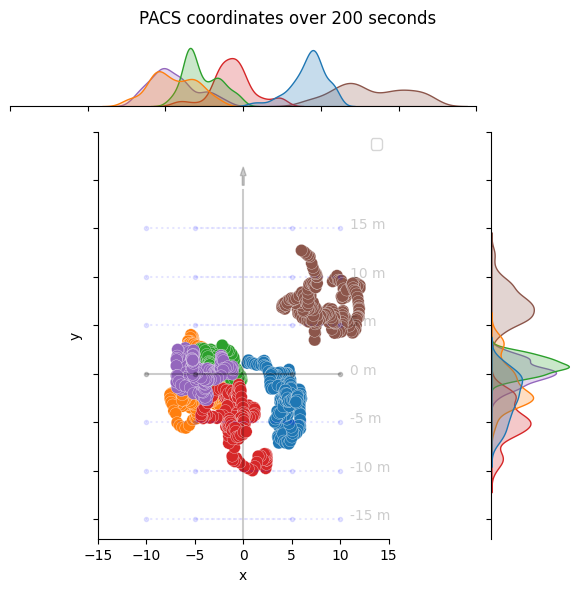

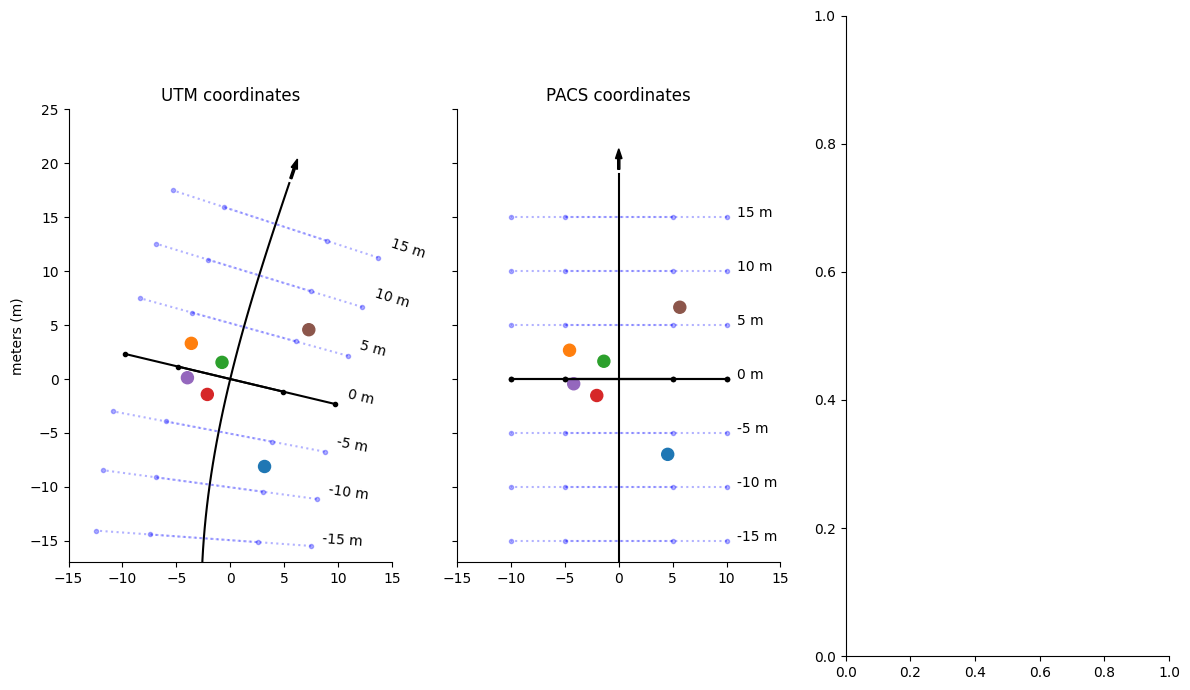

In [13]:
# example time period if random=False, random time period if random=True
PACS.plot_sample_PACS_figure(smooth_movements, ruck_slices_oriented, random = False)